# Network FKPP Prior and Posterior Predictive

In this notebook I will look at the prior and posterior predictive generative models for a Network FKPP model. 


## Environment 
First, document the environment and load necesary packages

In [1]:
using Pkg

In [2]:
Pkg.status()

Status `~/Projects/NetworkTopology/Project.toml`
  [b5ca4192] AdvancedVI v0.1.1
  [76274a88] Bijectors v0.8.14
  [a93c6f00] DataFrames v0.22.5
  [2b5f629d] DiffEqBase v6.57.5 `https://github.com/SciML/DiffEqBase.jl.git#sensitivity_interpolation`
  [41bf760c] DiffEqSensitivity v6.42.0
  [0c46a032] DifferentialEquations v6.16.0
  [31c24e10] Distributions v0.24.13
  [ced4e74d] DistributionsAD v0.6.19
  [f6369f11] ForwardDiff v0.10.16
  [7073ff75] IJulia v1.23.1
  [093fc24a] LightGraphs v1.3.5
  [c7f686f2] MCMCChains v4.7.0
  [91a5bcdd] Plots v1.10.4
  [c3e4b0f8] Pluto v0.12.21
  [37e2e3b7] ReverseDiff v1.5.0
  [f3b207a7] StatsPlots v0.14.19
  [fce5fe82] Turing v0.15.10
  [e88e6eb3] Zygote v0.6.3


In [3]:
using Random, DifferentialEquations, Turing, Plots, StatsPlots, MCMCChains, LightGraphs, Base.Threads

In [13]:
plotly()
uring.setadbackend(:forwarddiff);
Random.seed!(1);

┌ Info: For saving to png with the Plotly backend PlotlyBase has to be installed.
└ @ Plots /home/chaggar/.julia/packages/Plots/6EMd6/src/backends.jl:372


## Building the Network and Model

As with the diffusion model, the first step will be to construct a random network using `LightGraphs`. 

After this, we can define the Network FKPP equation: 

$\frac{d\mathbf{p}_i}{dt} = -k \sum\limits_{j=1}^{N}\mathbf{L}_{ij}^{\omega}\mathbf{p}_j + \alpha \mathbf{p}_i\left(1-\mathbf{p}_i\right)$"


In [5]:
function make_graph(N::Int64, P::Float64)
    G = erdos_renyi(N, P)
    L = laplacian_matrix(G)
    A = adjacency_matrix(G)
    return L, A
end

make_graph (generic function with 1 method)

In [6]:
function NetworkFKPP(u, p, t)
    κ, α = p 
    du = -κ * L * u .+ α .* u .* (1 .- u)
end

NetworkFKPP (generic function with 1 method)

## Solving the model for N = 5 

We can now solve the model for the network defined with five nodes. We do this using `DifferentialEquations`, using an adaptive step size numerical method.

We start by making a graph Erdos-Renyi random graph with connection probability of 0.5.

In [9]:
N = 5 
P = 0.5

L, A = make_graph(N, P);

Then we can set initial conditions to initialise the `ODEProblem` and numerically solve.

In [10]:
u0 = rand(N)
p = 1.5, 3
t_span = (0.0,2.0)

(0.0, 2.0)

In [11]:
problem = ODEProblem(NetworkFKPP, u0, t_span, p);

In [12]:
sol = solve(problem, AutoTsit5(Rosenbrock23()), saveat=0.05);

Next, we'll discretise this solution and add noise to simulate synethic data. 

In [26]:
data = clamp.(Array(sol) + 0.02 * randn(size(Array(sol))), 0.0,1.0);

In [27]:
plot(Array(sol)')
scatter!(data')

<!DOCTYPE html>
 
 
 Plots.jl

## Generative model and sampling from the prior

Now that we have a model and some synthetic data, we can create a generative model in `Turing` that aims to capture the data probablistically. In our case, the generative model is defined for data:

$$ \mathbf{y} = f(\mathbf{u0}, \rho) + \mathcal{N}(0, \sigma) $$

$$ \sigma = 0.02 $$ 

Our probablistic represention of these model parameters are given by: 

$$\sigma \approx \Gamma^{-1}(2, 3)$$ 
$$\kappa \approx \mathcal{N}(5,10,[0,10])$$
$$\alpha \approx \mathcal{N}(5,10,[0,10])$$
$$\mathbf{u0} \approx \mathcal{N}(0,2,[0,1])$$ 

In [18]:
@model function fitode(data, problem)
    σ ~ InverseGamma(2, 3)
    k ~ truncated(Normal(5,10.0),0.0,10)
    a ~ truncated(Normal(5,10.0),0.0,10)
    u ~ filldist(truncated(Normal(0.5,2.0),0.0,1.0), 5)

    p = [k, a] 

    prob = remake(problem, u0=u, p=p)

    predicted = solve(prob, Tsit5(), saveat=0.05)

    for i ∈ 1:length(predicted)
        data[:,i] ~ MvNormal(predicted[i], σ)
    end 
end

fitode (generic function with 1 method)

In [19]:
prior_chain = sample(fitode(data,problem), Prior(), 10_000)


Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05


Chains MCMC chain (10000×9×1 Array{Float64,3}):

Iterations        = 1:10000
Thinning interval = 1
Chains            = 1
Samples per chain = 10000
parameters        = a, k, u[1], u[2], u[3], u[4], u[5], σ
internals         = lp

Summary Statistics
  parameters      mean       std   naive_se      mcse          ess      rhat 
      Symbol   Float64   Float64    Float64   Float64      Float64   Float64 

           a    4.9929    2.8288     0.0283    0.0293   10027.0727    1.0000
           k    5.0025    2.8452     0.0285    0.0253    9971.3402    1.0000
        u[1]    0.4965    0.2877     0.0029    0.0031   10005.5924    0.9999
        u[2]    0.5054    0.2889     0.0029    0.0034    9870.0291    0.9999
        u[3]    0.4974    0.2867     0.0029    0.0032    9270.1321    1.0000
        u[4]    0.4986    0.2871     0.0029    0.0028   10469.1632    0.9999
        u[5]    0.5019    0.2869     0.0029    0.0031    9234.2871    0.9999
           σ    2.9458    4.2150     0.0422    0.0372   

In [20]:
chain_array = Array(prior_chain);

In [33]:
function plot_priorpredictive(node, sol, data, chain)
    plot(Array(sol)[node,:], w=2, legend = false)
    for k in 1:500
        par = chain[rand(1:10_000), 1:8]
        resol = solve(remake(problem,u0=par[3:7], p=par[1:2]),AutoTsit5(Rosenbrock23()),saveat=0.05)
        plot!(Array(resol)[node,:], alpha=0.5, color = "#BBBBBB", legend = false)
    end
    return scatter!(data[node,:], legend = false)
end

plot_priorpredictive (generic function with 1 method)

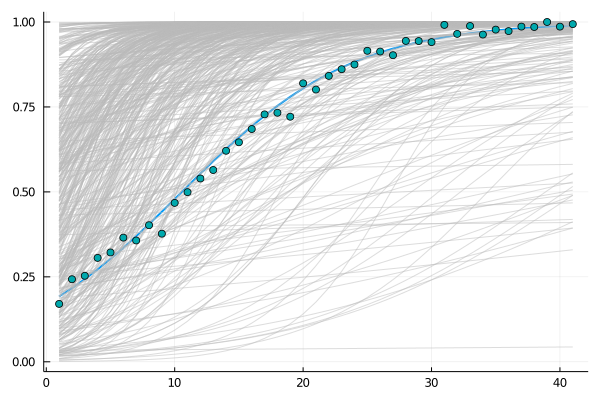

In [36]:
plot_priorpredictive(1, sol, data, chain_array)

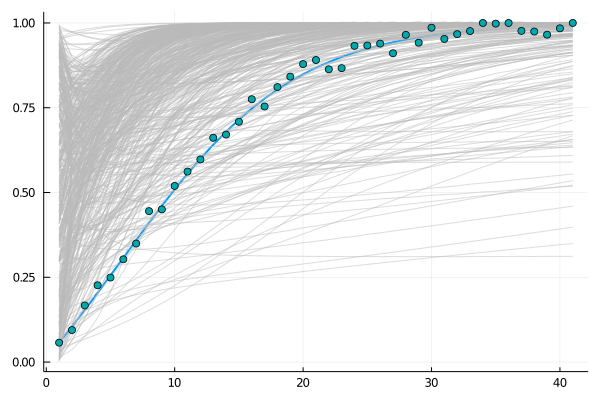

In [38]:
plot_priorpredictive(2, sol, data, chain_array)

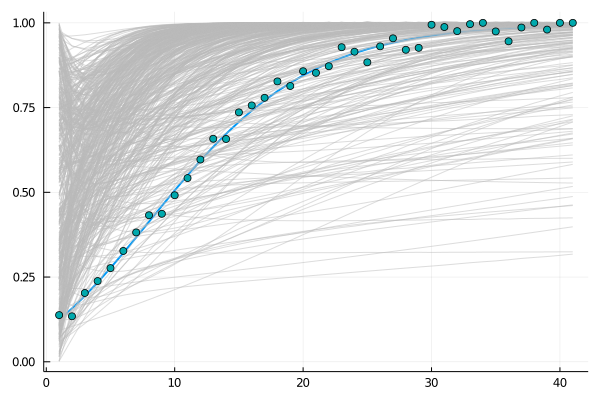

In [39]:
plot_priorpredictive(3, sol, data, chain_array)

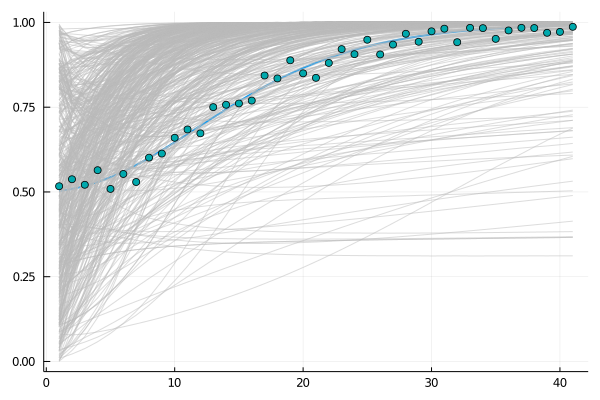

In [40]:
plot_priorpredictive(4, sol, data, chain_array)

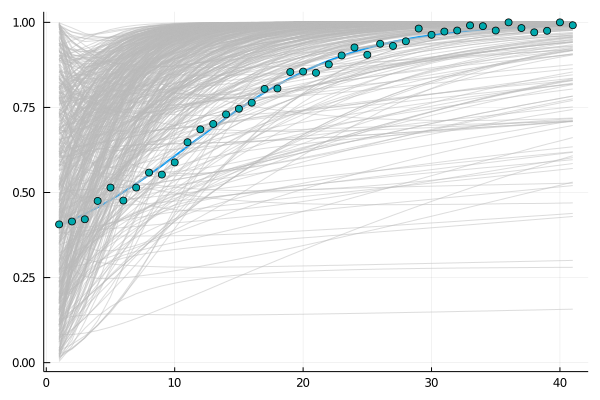

In [41]:
plot_priorpredictive(5, sol, data, chain_array)